# Heads-Up

In the notebook, some experiments will be run 
on A* algorithms, using both cosine similarity
and Euclidean distance as part of the heuristics.

# Thoughts

It seems that A* is capable of finding more human-like paths when given
geo-distances and directions as part of the heuristics, not necessarily
the optimal ones.

So how we can encode geo-information in weights, the sole factor that is
considered by Dijkstra, so that Dijkstra can be "smarter", not being just
optimal. 

One way to try is to multiply the geographic length of an edge
with a random factor within a range, e.g., [0.5, 1.0]. By doing this, we
add the speed limits and variations to each egde (i.e., road). This better
reflects real world road networks.
Hopefully, Dijkstra will become "smarter" and closer to A* while remaining
optimal.

# Visualization Matters

The plot of graph was refined a bit. Now the plot
actually reflects the geo-locations of each node
so that we can see with our eyes the paths whether they
are human-like or not.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import plot_g

In [ ]:
NUM_NODE = 100
WEIGHT_MIN = .0
WEIGHT_MAX = .5

def calc_euclidean_dist(G, tmp_node, node):
    
    p_1 = np.array([G.nodes[tmp_node]['x'], G.nodes[tmp_node]['y']])
    p_2 = np.array([G.nodes[node]['x'], G.nodes[node]['y']])
    return np.sqrt(np.sum((p_1 - p_2)**2))

def generate_low_degree_g(node_size=100, min_out_degree=2, max_out_degree=4, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):
    
    G = nx.Graph()
    
    grid_size = 1000
    euclidean_coords = np.linspace(0.01, 1.0, num=grid_size, endpoint=False)
    coords_indices = list(range(grid_size))
    
    random.shuffle(coords_indices)
    x_coords = euclidean_coords[coords_indices][:node_size]
#     print(x_coords)
    random.shuffle(coords_indices)
    y_coords = euclidean_coords[coords_indices][:node_size]
#     print(y_coords)
    
    # Add coordinates to nodes
    for node, coord in enumerate(zip(x_coords, y_coords)):
#         print(node, coord[0], coord[1])
        G.add_node(node, x=coord[0], y=coord[1])
    
    for node in G.nodes:
        
        tmp_nodes = list(G.nodes)
        tmp_nodes.remove(node)
        node_dist = map(lambda tmp_node: (tmp_node, calc_euclidean_dist(G, tmp_node, node)), tmp_nodes)
        node_dist = sorted(node_dist, key=lambda d:d[1])
        
        num_of_neighbors = random.randint(min_out_degree, max_out_degree)
#         print(node, out_neighbors)
        
#         G.add_edges_from(map(lambda d:(node, d), out_neighbors))
        
        for tmp_node in node_dist:

            if G.degree(tmp_node[0]) >= max_out_degree \
                or G.degree(node) >= num_of_neighbors:
                # This node has maximum number of neighbors already
                continue
            
            weight = random.uniform(weight_min, weight_max)
            G.add_edge(node, tmp_node[0], weight=weight)
    
    # Add centrality to edges
    edge_centrality = nx.edge_betweenness_centrality(G, \
                                                     k=G.number_of_nodes(), \
                                                     weight='weight')
    assert len(edge_centrality) == G.number_of_edges()
    
    for edge_data in G.edges.data():
        edge_data[2]['centrality'] = edge_centrality[(edge_data[0], edge_data[1])]
        
    return G

In [ ]:
# G = generate_low_degree_g(node_size=20)
plot_g(G)

In [ ]:
def calc_dot_dist(p1, p2):
    return np.dot(p1, p2)

def calc_geo_dist(p1, p2):
    
    p_1 = np.array(p1)
    p_2 = np.array(p2)
    
    return np.sqrt(np.sum((p_1 - p_2)**2))

def heuristic(node, dst):
    
    x_src = G.nodes[src]['x']
    y_src = G.nodes[src]['y']
    x_dst = G.nodes[dst]['x']
    y_dst = G.nodes[dst]['y']
    x_node = G.nodes[node]['x']
    y_node = G.nodes[node]['y']
    
    dist_src_2_dst = calc_geo_dist((x_src, y_src), (x_dst, y_dst))
    dot_src_2_node = calc_dot_dist((x_node-x_src, y_node-y_src), (x_dst-x_src, y_dst-y_src))
    ret = dist_src_2_dst - (dot_src_2_node) / dist_src_2_dst
    
    print(ret)
    return ret

In [ ]:
src, dst = 15, 4

print nx.astar_path(G, src, dst, heuristic=heuristic, weight='weight')
print nx.dijkstra_path(G, src, dst, weight='weight')

In [ ]:
for t in G.edges.data():
#     t[2]['weight'] = random.uniform(0.5, 1.0) * calc_euclidean_dist(G, t[0], t[1])
    print(t)

In [ ]:
for edge, centrality in nx.edge_betweenness_centrality(G).items():
    print(edge, centrality, G.get_edge_data(edge[0], edge[1])['weight'])

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-03-14 15:28:10.658621. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


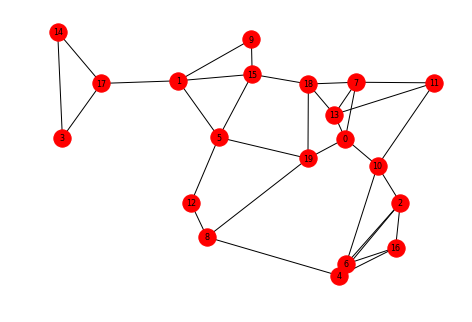

In [170]:
plot_g(G)